In [1]:
import torch.nn.functional as F
from torch import nn
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import UNetv2

In [2]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


def quadratic_beta_schedule(timesteps, start=0.0001, end=0.02):
    # Generate a linear space from 0 to 1
    linear_space = torch.linspace(0, 1, timesteps)
    
    # Apply a quadratic transformation
    quadratic_space = linear_space ** 2
    
    # Scale and shift the quadratic space to start and end at the specified values
    beta_values = start + (end - start) * quadratic_space
    
    return beta_values

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

IMG_SIZE = 64
BATCH_SIZE = 128
EPOCHS = 2000

# Define beta schedule
T = 250
betas = linear_beta_schedule(timesteps=T).to(device)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/ alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [4]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)

    test = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform, split='test')

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, prefetch_factor=4, num_workers=1)


In [5]:
model = UNetv2.GoodUNet(channel_sequence=[48, 96, 192, 384], time_emb_dim = 48, n=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(weight_decay=1e-4, params=model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.5)
checkpoint_epoch = 0

In [6]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

5064819

In [7]:
"""# Load checkpoint
checkpoint = torch.load('./checkpoints/model_checkpoint_10.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
checkpoint_epoch = checkpoint.get('epoch', None)"""

"# Load checkpoint\ncheckpoint = torch.load('./checkpoints/model_checkpoint_10.pth')\n\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nscheduler.load_state_dict(checkpoint['scheduler_state_dict'])\ncheckpoint_epoch = checkpoint.get('epoch', None)"

In [8]:
# Training algorithm
# x_0 ~ q(x_0)
# t ~ Uniform({1, ...., T})
# eps ~ N(0, I)
# Take graident descent step on MSE(eps - eps_theta(root(alpha_t_bar)*x_0 + root(1-alpha_t_bar)*eps, t))
# Until converged

for epoch in range(checkpoint_epoch, EPOCHS):
    # to keep track of accumulated accuracy
    epoch_loss = 0

    for step, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        t = torch.randint(1, T+1, (BATCH_SIZE,)).to(device)
        epsilon = torch.randn_like(images)

        noised_samples = (sqrt_alphas_cumprod[t - 1][(...,) + (None,) * 3] * images) + (sqrt_one_minus_alphas_cumprod[t - 1][(...,) + (None,) * 3] * epsilon)
        # [(...,) + (None,) * 3] is used so that I can turn the tensor of shape N to N 1 1 1, which allows me to multiply it with images and epsilon which have shape N C W H

        # Forward pass
        predicted_epsilon = model(noised_samples, t)
        loss = criterion(predicted_epsilon, epsilon)
        epoch_loss += loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (step+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{len(dataloader)}], Loss: {loss.item():.3f}')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}], Accumulated_Loss: {(epoch_loss.item() / (len(dataloader))):.3f}')
    scheduler.step()


Epoch [1/2000], Step [1/56], Loss: 1.189
Epoch [1/2000], Step [2/56], Loss: 3.581
Epoch [1/2000], Step [3/56], Loss: 1.595
Epoch [1/2000], Step [4/56], Loss: 1.107
Epoch [1/2000], Step [5/56], Loss: 1.158
Epoch [1/2000], Step [6/56], Loss: 1.250
Epoch [1/2000], Step [7/56], Loss: 1.146
Epoch [1/2000], Step [8/56], Loss: 1.090
Epoch [1/2000], Step [9/56], Loss: 1.119
Epoch [1/2000], Step [10/56], Loss: 1.071
Epoch [1/2000], Step [11/56], Loss: 1.017
Epoch [1/2000], Step [12/56], Loss: 1.021
Epoch [1/2000], Step [13/56], Loss: 1.051
Epoch [1/2000], Step [14/56], Loss: 1.063
Epoch [1/2000], Step [15/56], Loss: 1.048
Epoch [1/2000], Step [16/56], Loss: 1.018
Epoch [1/2000], Step [17/56], Loss: 1.001
Epoch [1/2000], Step [18/56], Loss: 1.009
Epoch [1/2000], Step [19/56], Loss: 1.021
Epoch [1/2000], Step [20/56], Loss: 1.023
Epoch [1/2000], Step [21/56], Loss: 1.021
Epoch [1/2000], Step [22/56], Loss: 1.018
Epoch [1/2000], Step [23/56], Loss: 1.011
Epoch [1/2000], Step [24/56], Loss: 1.005
E

KeyboardInterrupt: 

In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': 28
}

torch.save(checkpoint, './checkpoints/model_checkpoint_28.pth')

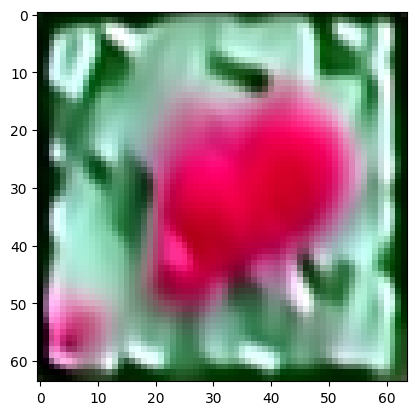

In [17]:
# Sampling algorithm
# for t = T, ... 1 do
# z ~ N(0, I) if t > 1, else z =0
# x_t-1 = 1/root(alpha_t) * (x_t - (1-alpha_t)/(root(1-alpha_t))*eps_theta(x_t, t)) + sigma_t*z
# end for
# return x_0

with torch.no_grad():
    x_current = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
    for i in range(T, 0, -1):
        z = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device) if i > 1 else torch.zeros(1, 3, IMG_SIZE, IMG_SIZE).to(device)
        epsilon_theta = model(x_current, torch.tensor([i - 1], device=device))
        x_current = sqrt_recip_alphas[i - 1] * (x_current - (((1 - alphas[i - 1])/(sqrt_one_minus_alphas_cumprod[i-1]))*epsilon_theta)) + (posterior_variance[i-1] * z)
        x_current = torch.clamp(x_current, -1.0, 1.0)

    show_tensor_image(x_current.cpu())